# The MNIST Data

In [1]:
from torchvision import datasets, transforms
# Specify post-processing pipeline
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.1307,), (0.3081,)), # mean and variance precomputed
                              ])
# Load train data from disk
trainset = datasets.MNIST('data/', download=True, train=True, transform=transform)

# Load validation data from disk
valset = datasets.MNIST('data/', download=True, train=False, transform=transform)  


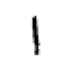

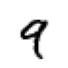

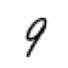

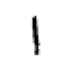

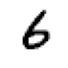

In [2]:
import matplotlib.pyplot as plt
# Look at a few images 
for i in [8,4,22,8,66]:
    image, label = trainset[i]
    plt.figure(figsize=(1,1))
    plt.imshow(image.numpy().squeeze(), cmap='gray_r');
    plt.axis('off')
    plt.show()
    plt.close()

# The Model

In [3]:
import torch
import numpy as np

def sigma(x):
    return x.clamp(min=0)

def random_param(shape, seed=7):
    torch.manual_seed(seed)              # Seed for reconstructability
    std = 1/np.sqrt(shape[-1])           # Standard deviation
    param = torch.normal(0., std, shape) # centered normal distributed parameters
    param.requires_grad=True             # Let them exhibit a gradient (torch specific) 
    return param

class NN():
    def __init__(self, dims=[784, 128, 64, 10]):
        self.theta = []                                       # Init parameter list
        for l in range(len(dims) -1 ):                        # iterate over each layer
            self.theta += [random_param((dims[l],dims[l+1]))] # Init weight matrix
        
    def forward(self, x):                  # Forward iteration
        for weights in self.theta:         # Iterate over weights, or layer
            x = sigma(x.matmul(weights))    # Forward iteration in each layer
        return x



# The Training

In [4]:
from torch import nn
from time import time

model = NN(dims=[784, 128, 64, 10])    # Initialize the neural network

lr = 0.002                             # Learning rate - gamma

epochs = 5                             # Number of times we to over the dataset

criterion = nn.CrossEntropyLoss()      # Another loss function thatn l2 distance

time0 = time()                         # Initialize the time (we want to know how long the computation takes)

for e in range(epochs):                         # Iterate over every epoch
    running_loss = 0
    for image, label in trainset:               # iterate over the dataset
        output = model.forward(image.flatten()) # Flatten MNIST images into a 784 long vector
        
        loss = criterion(output.unsqueeze(0),   # Distance between output and target
                         torch.tensor([label])) 
        
        loss.backward()                         # compute gradient
        
        # Update the weights with gradient descend 
        for param in model.theta:               # iterate over the parameters
            with torch.no_grad(): 
                param -= lr*param.grad          # update the parameters
                
            param.grad.zero_()                  # set the internal gradient to zero
        
        running_loss += loss.item()             # update loss

    print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainset)))
print("\nTraining time (in minutes) =",(time()-time0)/60)

Epoch 0 - Training loss: 0.2611920378975529
Epoch 1 - Training loss: 0.10623069500564518
Epoch 2 - Training loss: 0.06960197870077912
Epoch 3 - Training loss: 0.050545861576382974
Epoch 4 - Training loss: 0.03694207824729311

Training time (in minutes) = 4.242150131861369


# Check performance

In [5]:
test = 'validation' # 'training'

if test == 'validation':
    testset = valset
else:
    testset = trainset
compare = []
for image, label in testset:                             # Iterate over the test set
    prediction = model.forward(image.flatten()).argmax() # Get the model prediction of the image
    compare.append(prediction == label)                  # Check if the model was right

acc = float(sum(compare)/len(compare))                   # comppute total accuracy 
print('The accuracy on {} the set is {}%'.format(test,100*round(acc,4)))


The accuracy on validation the set is 96.69%


# Look at images where the model is wrong

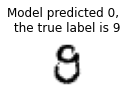

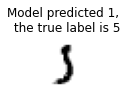

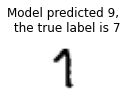

In [6]:
for i in range(300):
    image, label = trainset[i]
    prediction = model.forward(image.flatten()).argmax()
    if prediction != label:
        plt.figure(figsize=(1,1))
        plt.imshow(image.numpy().squeeze(), cmap='gray_r');
        plt.axis('off')
        plt.title("Model predicted {}, \n the true label is {}".format(prediction, label))
        plt.show()
        plt.close()